# Damped Simple Harmonic Oscillator

## The physics

The damped harmonic oscillator is a dissipative system, i.e energy is not conserved in the system, thus the concept of a Lagrangian is not properly defined. However, one can still define a 'Psuedo Lagrangian' that gives rise to the 'correct' equation of motion. It takes the following form:

$$
L =   \frac{1}{2} m\left(\frac{dx}{dt}\right)^2 + \gamma x \frac{dx}{dt} - \frac{1}{2} kx^2 
$$

Equation of motion (Euler Lagrange Equation) is given below

$$
m \dfrac{d^2x}{dt^2} + \gamma \frac{dx}{dt}= -kx~,
$$

where $m$ is the mass, $γ$ is the damping coefficient, $k$ is the spring constant, and $x$ is the displacement. The exact solution to the damped harmonic oscillator equation depends on the type of damping and there are three possible scenarios.

1. **Underdamped ($γ² < 4mk$)**: The system oscillates, but the amplitude of oscillation decreases over time. The solution is:

$$x(t) = e^{-\frac{γt}{2m}} [A \cos(ω_dt) + B \sin(ω_dt)]$$

where $ω_d = \frac{\sqrt{4mk - γ²}}{2m}$ is the damped angular frequency, and $A$ and $B$ are constants determined by initial conditions.

2. **Critically damped ($γ² = 4mk$)**: The system returns to equilibrium as quickly as possible without oscillating. The solution is:

$$x(t) = (A + Bt) e^{-\frac{γt}{2m}}$$

where $A$ and $B$ are constants determined by initial conditions.

3. **Overdamped ($γ² > 4mk$)**: The system returns to equilibrium without oscillating, but more slowly than the critically damped case. The solution is:

$$x(t) = e^{-\frac{γt}{2m}} [A e^{\frac{t\sqrt{γ² - 4mk}}{2m}} + B e^{-\frac{t\sqrt{γ² - 4mk}}{2m}}]$$

where $A$ and $B$ are constants determined by initial conditions.

Please note that these solutions assume that the right-hand side of the equation is zero, i.e., there are no external forces. If there are external forces, the solutions will be different. 

For the moment we will focus on the <u> underdamped</u> solution and assume that the the second sine term is zero (i.e B = 0).

## Import libraries

In [22]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn

## Useful functions

In [23]:
def exact_solution(d, w0, t):
    '''
    Exact solution of the underdamped harmonic oscillator with (B=0)

    Parameters:
    - d: Damping coefficient
    - w0: Natural frequency
    - t: Time

    Returns:
    - The exact solution of the underdamped harmonic oscillator at time t
    '''
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(w*t + phi)
    exp = torch.exp(-d*t)
    return 2*A*exp*cos

class FCN(nn.Module):
    '''Fully connected neural network with N_HIDDEN hidden layers and N_LAYERS layers.
    
    Args:
        N_INPUT (int): Number of input features.
        N_OUTPUT (int): Number of output features.
        N_HIDDEN (int): Number of hidden units in each hidden layer.
        N_LAYERS (int): Number of hidden layers.
    '''
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        """
        Initializes the DampedSHO class.

        Args:
            N_INPUT (int): Number of input features.
            N_OUTPUT (int): Number of output features.
            N_HIDDEN (int): Number of hidden units.
            N_LAYERS (int): Number of hidden layers.

        Returns:
            None
        """
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(*[
                nn.Sequential(*[ nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        """
        Performs the forward pass of the neural network.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.
        """
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x



## Train PiNN

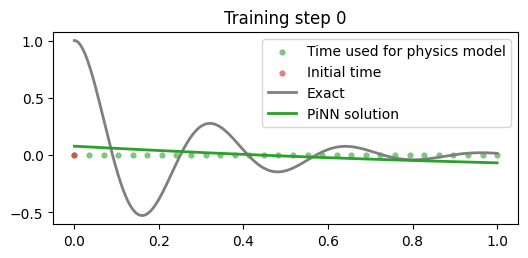

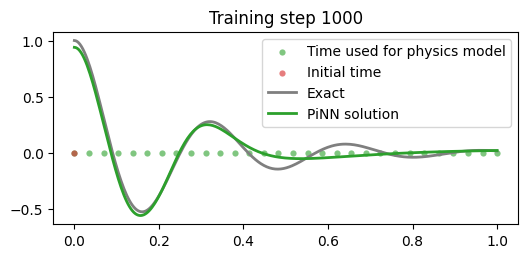

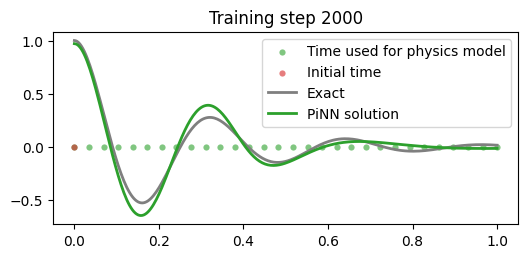

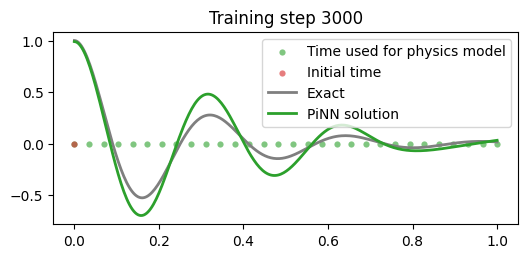

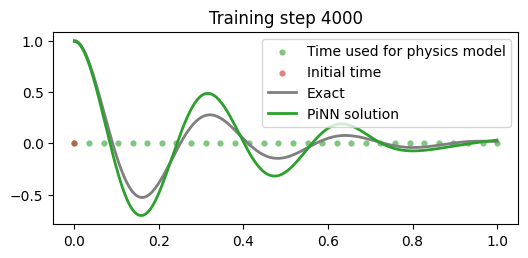

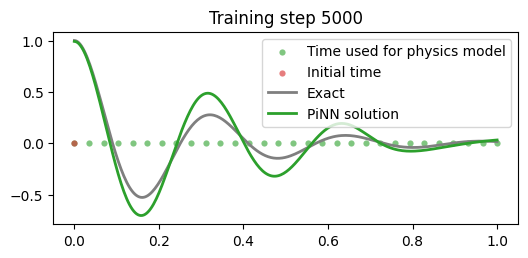

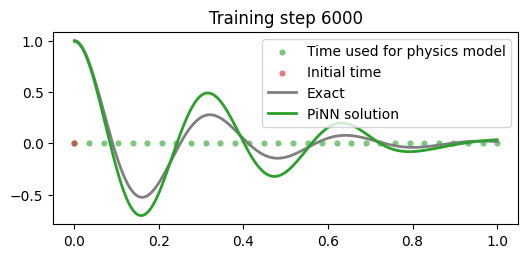

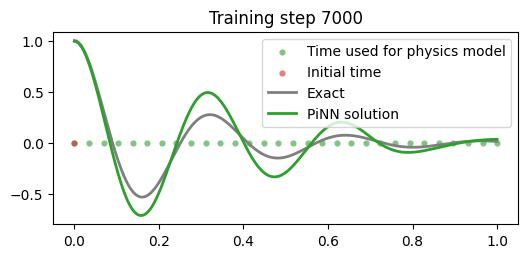

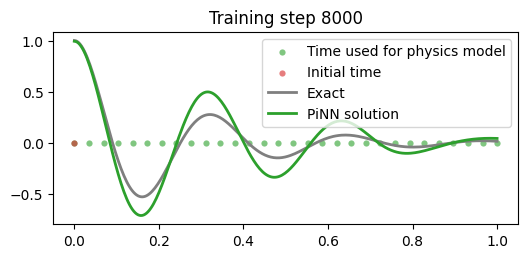

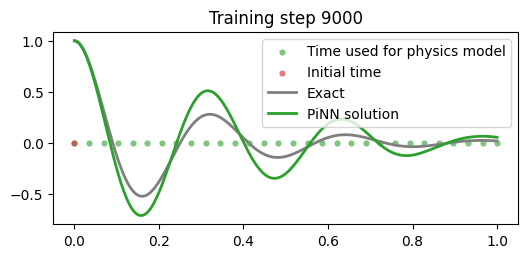

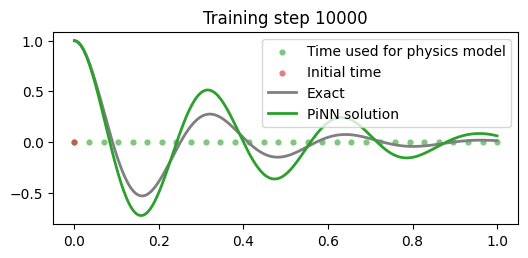

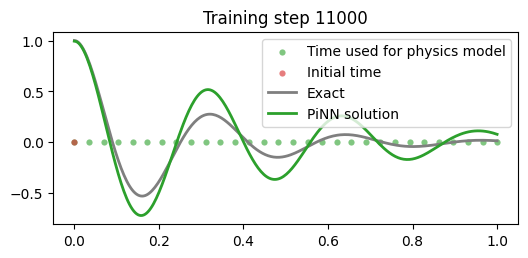

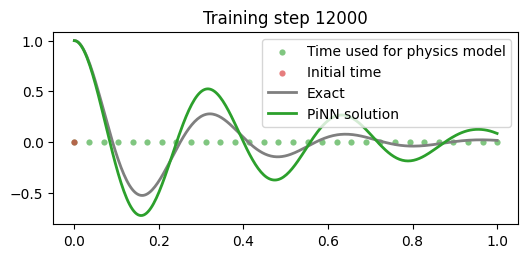

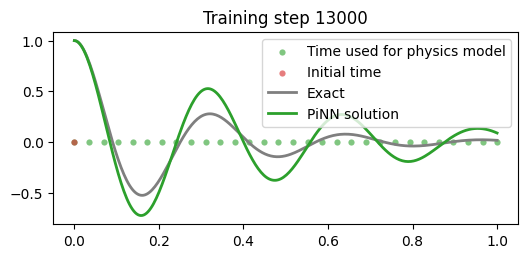

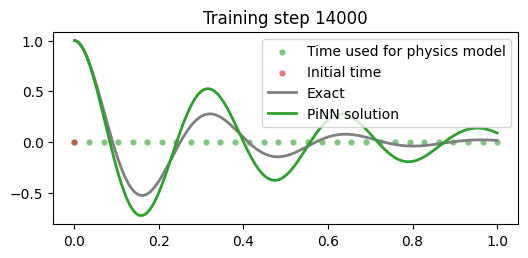

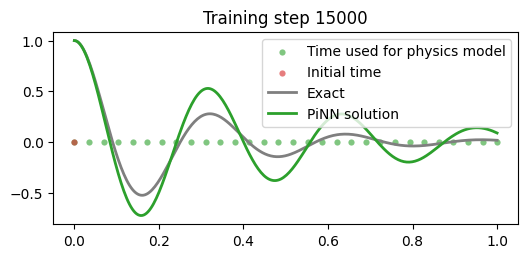

In [24]:
def train_pinn(t_boundary, t_physics, pinn, d, k, lambda1=1e-1, lambda2=1e-4, lr=1e-3, num_steps=15001, plot_interval=1000):
    """
    Trains a physics-informed neural network (PiNN) to solve a damped simple harmonic oscillator (SHO) problem.

    Args:
        t_boundary (torch.Tensor): Time point for the boundary condition.
        t_physics (torch.Tensor): Time points for the physics equation.
        pinn (nn.Module): The PiNN model.
        d (float): Damping coefficient.
        k (float): Spring constant.
        lambda1 (float): Weight for the boundary condition loss term.
        lambda2 (float): Weight for the physics equation loss term.
        lr (float): Learning rate for the optimizer.
        num_steps (int): Number of training steps.
        plot_interval (int): Interval for plotting the PiNN solution.

    Returns:
        None
    """
    optimiser = torch.optim.Adam(pinn.parameters(), lr=lr)
    for i in range(num_steps):
        optimiser.zero_grad()

        loss1 = (torch.squeeze(pinn(t_boundary)) - 1) ** 2

        dudt = torch.autograd.grad(pinn(t_boundary), t_boundary, torch.ones_like(pinn(t_boundary)), create_graph=True)[0]
        loss2 = (torch.squeeze(dudt) - 0) ** 2

        u = pinn(t_physics)
        dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
        d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
        loss3 = torch.mean((d2udt2 + d * dudt + k * u) ** 2)

        loss = loss1 + lambda1 * loss2 + lambda2 * loss3
        loss.backward()
        optimiser.step()

        if i % plot_interval == 0:
            plot_pinn_solution(t_physics, t_boundary, pinn, training_step=i)


def plot_pinn_solution(t_physics, t_boundary, pinn, training_step):
    """
    Plots the PiNN solution along with the exact solution and the time points used for training.

    Args:
        t_physics (torch.Tensor): Time points for the physics equation.
        t_boundary (torch.Tensor): Time point for the boundary condition.
        pinn (nn.Module): The PiNN model.

    Returns:
        None
    """
    t_test = torch.linspace(0, 1, 300).view(-1, 1)
    u_exact = exact_solution(d, w0, t_test)
    u = pinn(t_test).detach()

    plt.figure(figsize=(6, 2.5))
    plt.scatter(t_physics.detach()[:, 0], torch.zeros_like(t_physics)[:, 0], label='Time used for physics model',
                s=20, lw=0, color="tab:green", alpha=0.6)
    plt.scatter(t_boundary.detach()[:, 0], torch.zeros_like(t_boundary)[:, 0], label='Initial time',
                s=20, lw=0, color='tab:red', alpha=0.6)
    plt.plot(t_test[:, 0], u_exact[:, 0], label='Exact', color='tab:grey', lw=2)
    plt.plot(t_test[:, 0], u[:, 0], label='PiNN solution', color='tab:green', lw=2)
    plt.title(f'Training step {training_step}')
    plt.legend()
    plt.show()


# Training the PiNN
torch.manual_seed(123)

pinn = FCN(1, 1, 32, 3)
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

d, w0 = 2, 20
d, k = 2 * d, w0 ** 2

train_pinn(t_boundary, t_physics, pinn, d, k)
                                                                                        

## Inverse problem: Solving for damping coefficient

### Generate noisy data

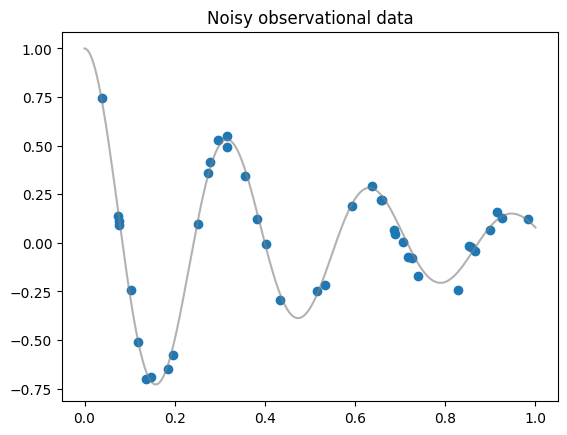

In [36]:
def generate_noisy_data(d, w0, num_points, noise_std):
    """
    Generates noisy observational data for the damped simple harmonic oscillator.

    Args:
        d (float): Damping coefficient.
        w0 (float): Natural frequency.
        num_points (int): Number of data points to generate.
        noise_std (float): Standard deviation of the noise.

    Returns:
        torch.Tensor: Time points.
        torch.Tensor: Noisy observational data.
    """
    torch.manual_seed(123)
    t_obs = torch.rand(num_points).view(-1, 1)
    u_obs = exact_solution(d, w0, t_obs) + noise_std * torch.randn_like(t_obs)
    return t_obs, u_obs

# Example usage
d = 2
w0 = 20
num_points = 40
noise_std = 0.04

t_obs, u_obs = generate_noisy_data(d, w0, num_points, noise_std)

# Plotting the data
plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:, 0], u_obs[:, 0])
t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)
plt.plot(t_test[:, 0], u_exact[:, 0], label='Exact solution', color='tab:grey', alpha=0.6)
plt.show()

### Using PiNN to learn damping coefficient: Inverse problem

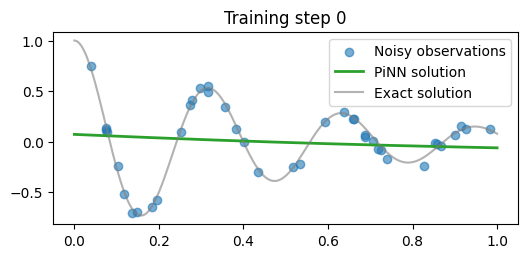

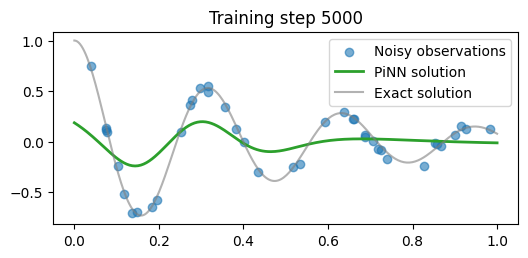

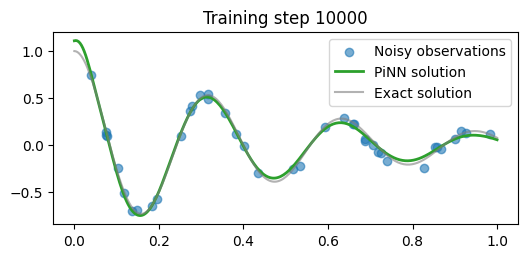

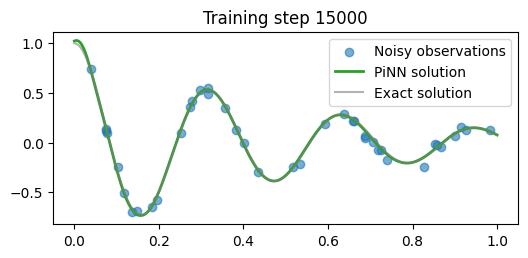

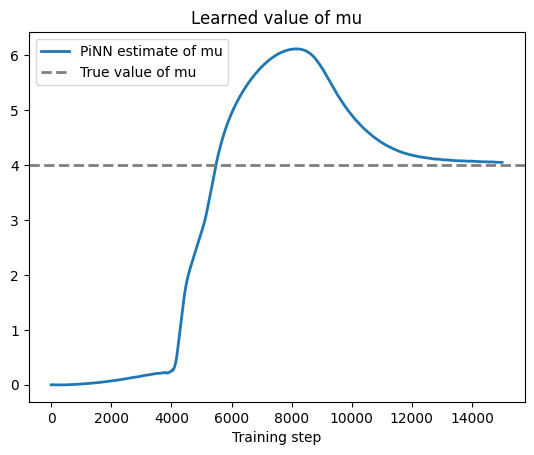

In [38]:
def train_pinn_inverse(t_physics, t_obs, u_obs, pinn, d, k, lambda1=1e4, lr=1e-3, num_steps=15001, plot_interval=5000):
    """
    Trains a physics-informed neural network (PiNN) to solve the inverse problem of estimating the damping coefficient.

    Args:
        t_physics (torch.Tensor): Time points for the physics equation.
        t_obs (torch.Tensor): Time points for the observed data.
        u_obs (torch.Tensor): Observed data.
        pinn (nn.Module): The PiNN model.
        d (float): Damping coefficient.
        k (float): Spring constant.
        lambda1 (float): Weight for the loss term of the physics equation.
        lr (float): Learning rate for the optimizer.
        num_steps (int): Number of training steps.
        plot_interval (int): Interval for plotting the PiNN solution.

    Returns:
        None
    """
    mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
    optimiser = torch.optim.Adam([mu] + list(pinn.parameters()), lr=lr)
    mus = []
    for i in range(num_steps):
        optimiser.zero_grad()

        u = pinn(t_physics)
        dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
        d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
        loss1 = torch.mean((d2udt2 + mu * dudt + k * u) ** 2)

        u = pinn(t_obs)
        loss2 = torch.mean((u - u_obs) ** 2)

        loss = loss1 + lambda1 * loss2
        loss.backward()
        optimiser.step()

        mus.append(mu.item())

        if i % plot_interval == 0:
            plot_pinn_inverse_solution(t_obs, u_obs, t_physics, pinn, mu, d, k, training_step=i)

    plot_mu_estimate(mus, d)


def plot_pinn_inverse_solution(t_obs, u_obs, t_physics, pinn, mu, d, k, training_step):
    """
    Plots the PiNN solution for the inverse problem along with the observed data and the true solution.

    Args:
        t_obs (torch.Tensor): Time points for the observed data.
        u_obs (torch.Tensor): Observed data.
        t_physics (torch.Tensor): Time points for the physics equation.
        pinn (nn.Module): The PiNN model.
        mu (torch.Tensor): Estimated value of mu.
        d (float): Damping coefficient.
        k (float): Spring constant.
        training_step (int): Current training step.

    Returns:
        None
    """
    t_test = torch.linspace(0, 1, 300).view(-1, 1)
    u_exact = exact_solution(d, w0, t_test)
    u = pinn(t_test).detach()

    plt.figure(figsize=(6, 2.5))
    plt.scatter(t_obs.detach()[:, 0], u_obs.detach()[:, 0], label='Noisy observations', alpha=0.6)
    plt.plot(t_test[:, 0], u[:, 0], label='PiNN solution', color='tab:green', lw=2)
    plt.plot(t_test[:, 0], u_exact[:, 0], label='Exact solution', color='tab:grey', alpha=0.6)
    plt.title(f'Training step {training_step}')
    plt.legend()
    plt.show()


def plot_mu_estimate(mus, d):
    """
    Plots the learned value of mu over the training steps.

    Args:
        mus (list): List of estimated values of mu.
        true_mu (float): True value of mu.

    Returns:
        None
    """
    plt.figure()
    plt.title("Learned value of mu")
    plt.plot(mus, label='PiNN estimate of mu', color='tab:blue', lw=2)
    plt.axhline(2*d, label='True value of mu', color='tab:grey', lw=2, ls='--')
    plt.legend()
    plt.xlabel('Training step')
    plt.show()


# Training the PiNN for the inverse problem
torch.manual_seed(123)

pinn = FCN(1, 1, 32, 3)
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
t_obs, u_obs = generate_noisy_data(d, w0, num_points, noise_std)

train_pinn_inverse(t_physics, t_obs, u_obs, pinn, d, k)
